In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
from glob import glob
from keras.models import load_model
from scipy.ndimage import gaussian_filter, maximum_filter, minimum_filter
from deepsky.gan import unnormalize_multivariate_data
from skimage.morphology import disk

Using TensorFlow backend.


In [8]:
data_path = "/scratch/dgagne/spatial_storm_results_20171220/"

In [9]:
scores = ["auc", "bss"]
models = ["conv_net", "logistic_mean", "logistic_gan", "logistic_pca"]
imp_scores = {}
for model in models:
    imp_scores[model] = {}
    for score in scores:
        score_files = sorted(glob(data_path + "var_importance_{0}_{1}_*.csv".format(model, score)))
        imp_score_list = []
        for score_file in score_files:
            print(score_file)
            imp_data = pd.read_csv(score_file, index_col="Index")
            imp_score_list.append(((imp_data.iloc[0,0] - imp_data.loc[1:]) / imp_data.iloc[0,0] * 100).mean(axis=0))
        imp_scores[model][score] = pd.concat(imp_score_list, axis=1).T
        imp_scores[model][score].columns = imp_scores[model][score].columns.str.rstrip("_prev"
                                                                    ).str.replace("_", " "
                                                                    ).str.replace("-component of", ""
                                                                    ).str.replace("dew point temperature", "dew point")

/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_000.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_001.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_002.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_003.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_004.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_005.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_006.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_007.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_008.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_009.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_010.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_conv_net_auc_011.csv
/scr

/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_011.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_012.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_013.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_014.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_015.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_016.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_017.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_018.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_019.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_020.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_mean_bss_021.csv
/scratch/dgagne/spatial_storm_re

/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_auc_022.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_auc_023.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_auc_024.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_auc_025.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_auc_026.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_auc_027.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_auc_028.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_auc_029.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_bss_000.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_bss_001.csv
/scratch/dgagne/spatial_storm_results_20171220/var_importance_logistic_pca_bss_002.csv
/scratch/dgagne/spatial_storm_results_20171

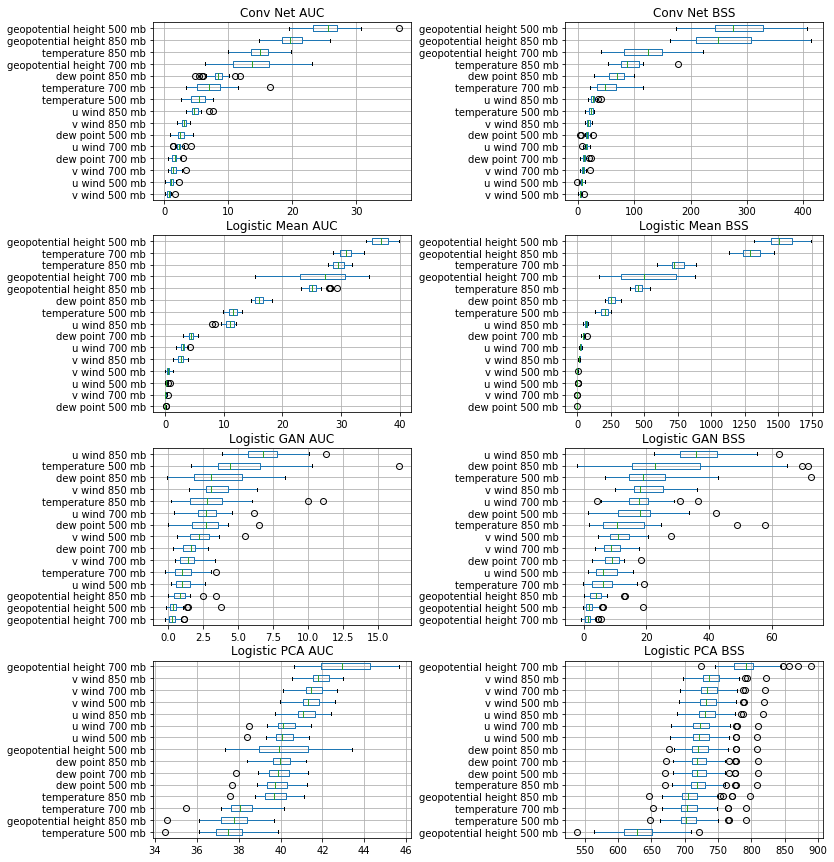

In [11]:
fig, axes = plt.subplots(4, 2, figsize=(12, 15))
plt.subplots_adjust(wspace=0.6)
model_titles = ["Conv Net", "Logistic Mean", "Logistic GAN", "Logistic PCA"]
for m, model in enumerate(models):
    for s, score in enumerate(scores):
        rankings = imp_scores[model][score].mean(axis=0).sort_values().index
        imp_scores[model][score].loc[:, rankings].boxplot(ax=axes[m,s], vert=False)
        axes[m, s].set_title(model_titles[m] + " " + score.upper())
plt.savefig("var_imp_box.png", dpi=300, bbox_inches="tight")

In [137]:
mean_imp_matrix = pd.DataFrame(index=imp_scores["conv_net"]["bss"].columns, columns=models, dtype=float)
mean_imp_rank_matrix = pd.DataFrame(index=imp_scores["conv_net"]["bss"].columns, columns=models, dtype=int)
for model in models:
    mean_imp_matrix.loc[:, model] = imp_scores[model]["bss"].values.mean(axis=0)
    rank = np.argsort(imp_scores[model]["bss"].values.mean(axis=0))
    for r in range(rank.size):
        mean_imp_rank_matrix.loc[mean_imp_rank_matrix.index[rank[r]], model] = rank.size - r


In [93]:
mean_imp_matrix["conv_net"].values[np.argsort(mean_imp_matrix["conv_net"].values)]

array([  0.68831654,   1.13451656,   1.44212821,   1.55460714,
         2.2877488 ,   2.57388041,   3.05342006,   4.78460331,
         5.16755414,   7.18191937,   8.33550156,  13.72857337,
        14.8664198 ,  19.72752819,  25.62117955])

In [138]:
mean_imp_rank_matrix

,conv_net,logistic_mean,logistic_gan,logistic_pca
geopotential height 500 mb,1,1,14,15
geopotential height 700 mb,3,4,15,1
geopotential height 850 mb,2,2,13,12
temperature 500 mb,8,7,3,14
temperature 700 mb,6,3,12,13
temperature 850 mb,4,5,7,11
dew point 500 mb,10,15,6,10
dew point 700 mb,12,9,10,9
dew point 850 mb,5,6,2,8
u wind 500 mb,14,13,11,7


In [4]:
scaling_values = pd.read_csv("/d1/dgagne/spatial_storm_results_20171220/scaling_values.csv", index_col="Index")
scaling_values

,mean,std
Index,,
0,5788.919434,65.136246
1,3109.552979,49.678848
2,1481.663574,45.307823
3,261.454987,2.581064
4,279.288055,2.373210
5,289.850830,2.915570
6,253.631378,8.898883
7,274.562805,4.148108
8,285.562958,3.813218


In [3]:
cnn = load_model("/d1/dgagne/spatial_storm_results_20171220/hail_conv_net_sample_000.h5")

In [34]:
cnn_weights = cnn.layers[-2].get_weights()[0][:, 0]

In [59]:
cnn_weights[1960]

0.054301988

In [35]:
cnn_weights.argsort()[::-1][0:10], cnn_weights[90]

(array([  90, 1583, 1960, 1923,  138,  459,  607, 1793,   10, 2030]),
 0.057643231)

(array([ 389.,  365.,  370.,  333.,  275.,  154.,  103.,   46.,    7.,    6.]),
 array([  6.72834358e-06,   5.85218002e-03,   1.16976317e-02,
          1.75430834e-02,   2.33885351e-02,   2.92339867e-02,
          3.50794384e-02,   4.09248901e-02,   4.67703418e-02,
          5.26157935e-02,   5.84612451e-02]),
 <a list of 10 Patch objects>)

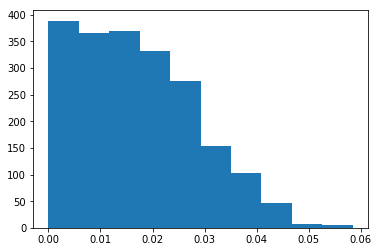

In [205]:
plt.hist(np.abs(cnn_weights))

In [169]:
encoding_data = pd.read_csv("/d1/dgagne/spatial_storm_results_20171220/encoding_conv_net_000.csv")

In [189]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
run_date = 2016052400
run_data = encoding_data.loc[encoding_data["run_dates"] == run_date]
enc_columns = ["E{0:03d}".format(x) for x in range(2048)]
pc = PCA(n_components=5)
pc_out = pc.fit_transform(run_data[enc_columns])

In [181]:
ts = TSNE(n_components=2)
ts_out = ts.fit_transform(run_data[enc_columns])

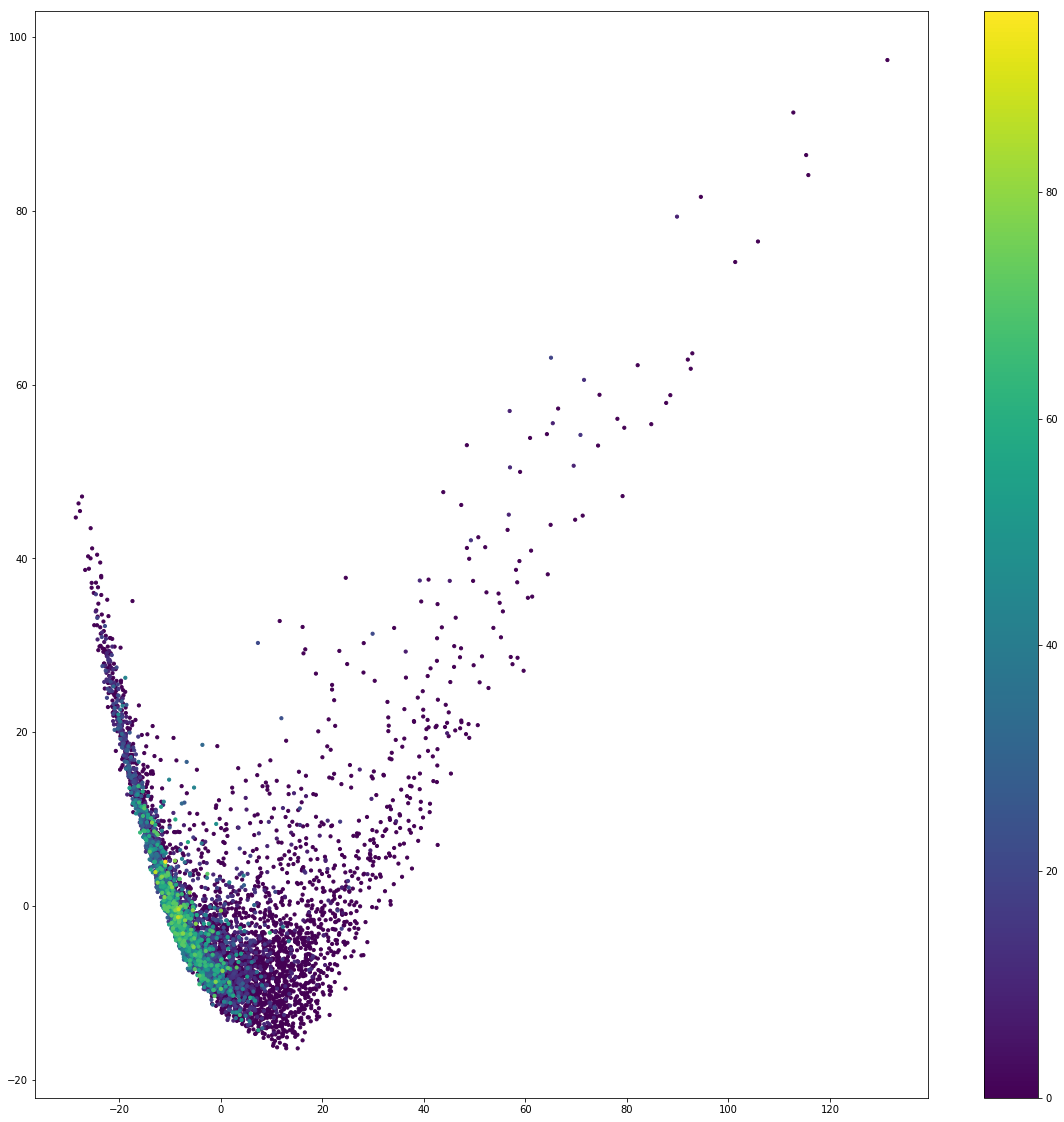

In [196]:
plt.figure(figsize=(20, 20))
size_order = np.argsort(run_data["max_hail_size"].values)
plt.scatter(pc_out[size_order, 0], pc_out[size_order,1], 10, run_data["max_hail_size"].values[size_order])
plt.colorbar()

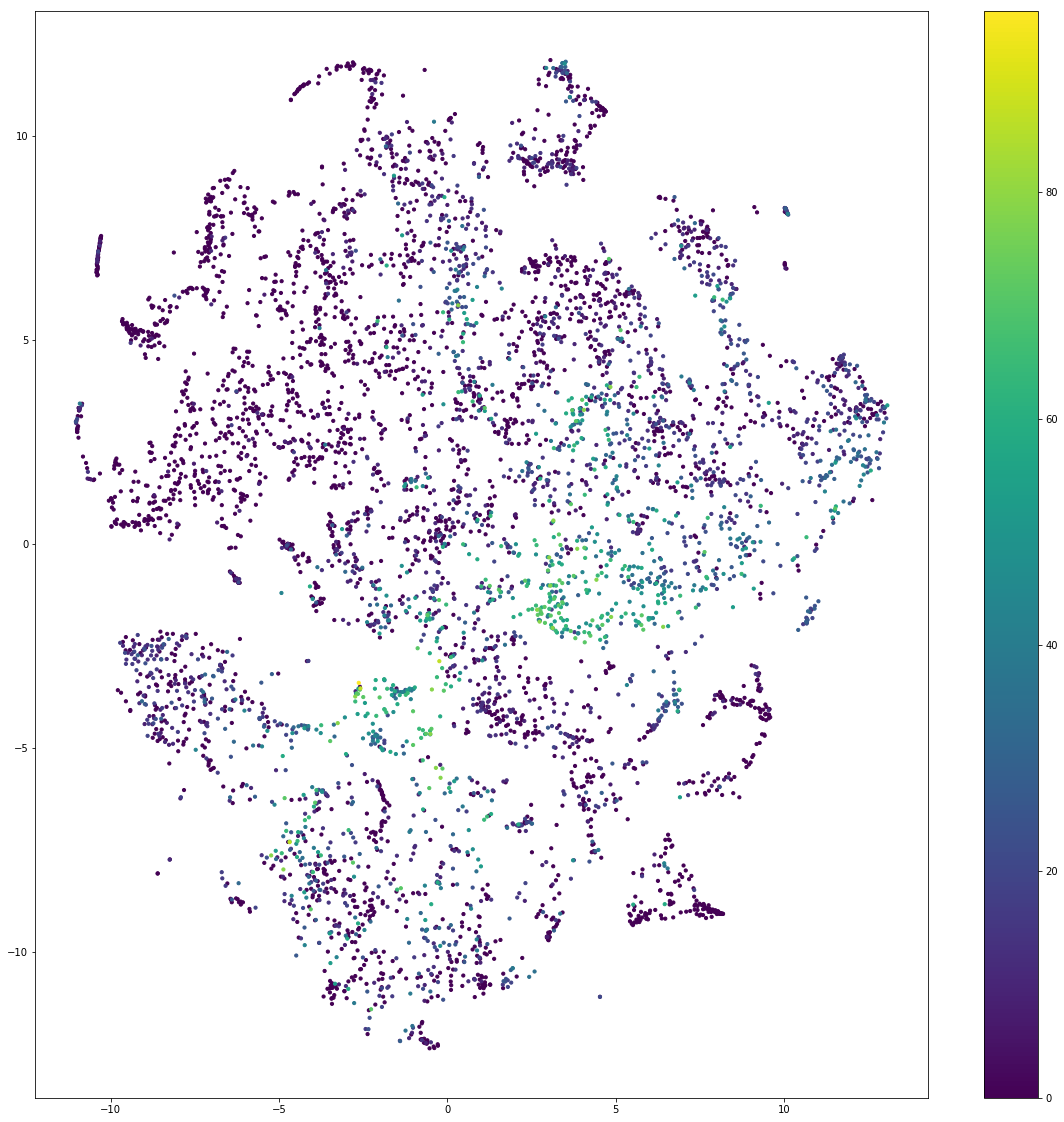

In [197]:
plt.figure(figsize=(20, 20))
size_order = np.argsort(run_data["max_hail_size"].values)
plt.scatter(ts_out[size_order, 0], ts_out[size_order,1], 10, run_data["max_hail_size"].values[size_order])
plt.colorbar()

In [92]:
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 15)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 32)        12032     
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 64)          0         
__________

In [105]:
def visualize_layer(cnn_model, neuron, out_prob, err_min=0.01, dropout=False, max_iter=100, lr=0.001):
    layer_out = cnn_model.layers[-3].output[0, neuron]
    input_image = cnn_model.layers[0].input
    loss = (out_prob - layer_out) ** 2
    #loss = out_prob - layer_out
    grads = K.gradients(loss, input_image)[0]
    print(grads)
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_image, K.learning_phase()], 
                         [layer_out, loss, grads])
    #input_img_data = np.zeros((1, 32, 32, 15))
    #input_img_data = np.random.normal(scale=0.01, size=(1, 32, 32, 15))
    input_img_data = np.zeros((1, 32, 32, 15))
    input_img_data[0, 10:15, 10:15] = -3
    loss_value = 100
    n = 0
    while loss_value > err_min and n < max_iter:
        out_val, loss_value, grads_value = iterate([input_img_data, dropout])
        if n % 5 == 0:
            print(n, out_val, loss_value, grads_value.max())
        input_img_data -= grads_value * lr
        n += 1
    return input_img_data


def visualize_filter(cnn_model, neuron, out_prob, err_min=0.01, dropout=False, max_iter=100, lr=0.1):
    filter_index = np.unravel_index(neuron, (1, 4, 4, 128))[-1]
    layer_out = K.max(cnn_model.layers[-6].output[0, :, :, filter_index])
    input_image = cnn_model.layers[0].input
    loss = (out_prob - layer_out) ** 2
    #loss = out_prob - layer_out
    grads = K.gradients(loss, input_image)[0]
    print(grads)
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    iterate = K.function([input_image, K.learning_phase()], 
                         [layer_out, loss, grads])
    #input_img_data = np.zeros((1, 32, 32, 15))
    input_img_data = np.random.normal(scale=0.01, size=(1, 32, 32, 15))
    #input_img_data = np.zeros((1, 32, 32, 15))
    #input_img_data[0, 10:15, 10:15] = -3
    loss_value = 100
    n = 0
    while loss_value > err_min and n < max_iter:
        out_val, loss_value, grads_value = iterate([input_img_data, dropout])
        if n % 5 == 0:
            print(n, out_val, loss_value, grads_value.max())
        input_img_data -= grads_value * lr
        n += 1
    return input_img_data


def smooth_channels(storm_cube):
    smooth_cube = np.zeros(storm_cube.shape)
    ds = disk(2)
    for c in range(storm_cube.shape[-1]):
        out_channel = storm_cube[0, :, :, c]
        out_smooth = gaussian_filter(out_channel, 2)
        out_pos = np.zeros(out_channel.shape)
        out_neg = np.zeros(out_channel.shape)
        out_pos[out_smooth > 0] = out_channel[out_smooth > 0]
        out_neg[out_smooth < 0] = out_channel[out_smooth < 0]
        max_pos = maximum_filter(out_pos, footprint=ds)
        min_neg = minimum_filter(out_neg, footprint=ds)
        out_proc = np.zeros(out_channel.shape)
        out_proc[out_smooth > 0] = max_pos[out_smooth > 0]
        out_proc[out_smooth < 0] = min_neg[out_smooth < 0]
        smooth_cube[:, :, :, c] = out_proc
        smooth_cube[:, :, :, c] = gaussian_filter(smooth_cube[:, :, :, c], 1)
        #smooth_cube[:, :, :, c] = maximum_filter(storm_cube[:, :, :, c], filter_sd)
        #smooth_cube[:, :, :, c] /= smooth_cube[:, :, :, c].std()
    return smooth_cube

def plot_input_raw(fields, network, neuron, neuron_rank):
    fig = plt.figure(figsize=(12, 4))
    heights = [500, 700, 850]
    for a in np.arange(3):
        plt.subplot(1,3, a + 1)
        conts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5]
        hght = plt.contourf(fields[0, :, :, a], conts, extend="both", cmap="RdBu_r")
        tmpc = plt.contour(fields[0, :, :, 3 + a], 
                           conts, linewidths=3, colors=["red"])
        plt.clabel(tmpc, fmt="%1.1f", fontsize=14)
        dewp = plt.contour(fields[0, :, :, 6 + a], conts, linewidths=2, colors=["green"])
        plt.clabel(dewp, fmt="%1.1f", fontsize=14)
        u_g = fields[0, :, :, 9 + a]
        v_g = fields[0, :, :, 12 + a]
        #wind_mask = np.sqrt(out_smooth[0, :, :, 9 + a] ** 2 + out_smooth[0, :, :, 12 + a] ** 2) < 0.01
        #u_g[wind_mask] = 0
        #v_g[wind_mask] = 0
        plt.quiver(np.arange(32), np.arange(32), u_g,
                  v_g, color="k")
        plt.xticks(np.arange(0, 32, 8))
        plt.yticks(np.arange(0, 32, 8))
        plt.title("{0:d} mb".format(heights[a]), fontsize=14)
    plt.suptitle("Conv Net {0:02d} Hailstorm Neuron {1:03d}, Rank {2:03d}".format(network, neuron, neuron_rank), fontsize=16, y=0.99)
    plt.savefig("/d1/dgagne/spatial_storm_results_20171220/hail_dream_figures/best_hail_act_net_{0:02d}_rank_{1:03d}_neuron_{2:03d}.png".format(network, neuron_rank, neuron), 
                dpi=200, bbox_inches="tight")
    plt.close()

    
def plot_input_original(fields, network, neuron, neuron_rank):
    fig = plt.figure(figsize=(12, 4))
    heights = [500, 700, 850]
    for a in np.arange(3):
        plt.subplot(1,3, a + 1)
        hght = plt.contourf(fields[0, :, :, a], 4, extend="both", cmap="RdBu_r")
        tmpc = plt.contour(fields[0, :, :, 3 + a] - 273, 4, linewidths=3, colors=["red"])
        plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
        dewp = plt.contour(fields[0, :, :, 6 + a] - 273, 4, linewidths=2, colors=["green"])
        plt.clabel(dewp, fmt="%1.0f", fontsize=14)
        u_g = fields[0, :, :, 9 + a]
        v_g = fields[0, :, :, 12 + a]
        #wind_mask = np.sqrt(out_smooth[0, :, :, 9 + a] ** 2 + out_smooth[0, :, :, 12 + a] ** 2) < 1
        #u_g[wind_mask] = 0
        #v_g[wind_mask] = 0
        plt.barbs(np.arange(2, 32, 2), np.arange(2, 32, 2), u_g[2::2, 2::2],
                  v_g[2::2, 2::2], color="k", length=4)
        plt.xticks(np.arange(0, 32, 8))
        plt.yticks(np.arange(0, 32, 8))
        plt.title("{0:d} mb".format(heights[a]), fontsize=14)
    plt.suptitle("Conv Net {0:02d} Hailstorm Neuron {1:03d}, Rank {2:03d}".format(network, neuron, neuron_rank), fontsize=16, y=0.99)
    plt.savefig("/d1/dgagne/spatial_storm_results_20171220/hail_dream_figures/best_original_hail_act_net_{0:02d}_rank_{1:03d}_neuron_{2:03d}.png".format(network, neuron_rank, neuron), 
                dpi=200, bbox_inches="tight")
    plt.close()

In [106]:
cnn_weights = cnn.layers[-2].get_weights()[0][:, 0]
top_pos_neurons = cnn_weights.argsort()[::-1][0:10]
for rank, neuron in enumerate(top_pos_neurons):
    print(rank, neuron)
    out_image = visualize_filter(cnn, neuron, 1, dropout=False, lr=0.01)
    out_smooth = smooth_channels(out_image)
    out_orig = unnormalize_multivariate_data(out_smooth, scaling_values)
    plot_input_raw(out_smooth, 0, neuron, rank + 1)
    plot_input_original(out_orig, 0, neuron, rank + 1)

0 90
Tensor("gradients_175/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, 32, 32, 15), dtype=float32)
0 0.724996 0.075627 7.15305
5 0.826063 0.030254 8.59364
1 1583
Tensor("gradients_176/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, 32, 32, 15), dtype=float32)
0 0.339942 0.435676 8.57177
5 0.415122 0.342083 8.02159
10 0.958531 0.00171964 15.857


/Users/dgagne/anaconda3/lib/python3.5/site-packages/matplotlib/contour.py:370: RuntimeWarning: invalid value encountered in true_divide
  dist = np.add.reduce(([(abs(s)[i] / L[i]) for i in range(xsize)]), -1)


2 1960
Tensor("gradients_177/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, 32, 32, 15), dtype=float32)
0 0.195518 0.647191 6.817
5 0.257292 0.551615 13.3482
10 0.504008 0.246008 11.9153
15 0.884105 0.0134317 12.4539
3 1923
Tensor("gradients_178/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, 32, 32, 15), dtype=float32)
0 0.463641 0.287681 7.48002
5 0.544724 0.207276 7.25963
10 0.593184 0.1655 9.6759
15 0.655083 0.118968 14.2393
20 0.937649 0.00388762 12.3431
4 138
Tensor("gradients_179/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, 32, 32, 15), dtype=float32)
0 0.151065 0.720691 12.6998
5 0.353814 0.417556 17.1823
10 0.963581 0.00132634 13.9544
5 459
Tensor("gradients_180/conv2d_1/convolution_grad/Conv2DBackpropInput:0", shape=(?, 32, 32, 15), dtype=float32)
0 -0.0 1.0 0.0
5 -0.0 1.0 0.0
10 -0.0 1.0 0.0
15 -0.0 1.0 0.0
20 -0.0 1.0 0.0
25 -0.0 1.0 0.0
30 -0.0 1.0 0.0
35 -0.0 1.0 0.0
40 -0.0 1.0 0.0
45 -0.0 1.0 0.0
50 -0.0 1.0 0.0
55 -0.0 1.0 0.0
60

In [61]:
import keras.backend as K
out_image = visualize_layer(cnn, 434, 2, lr=0.1)
out_smooth = smooth_channels(out_image)
out_orig = unnormalize_multivariate_data(out_smooth, scaling_values=scaling_values)

0 0.802607 14.0244
5 0.911422 13.1588
10 0.551003 9.68963


4.02167


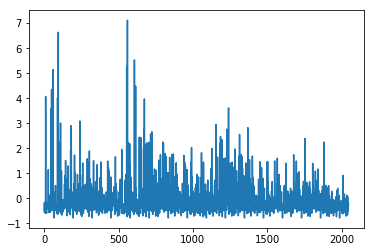

In [164]:
enc_func = K.function([cnn.input, K.learning_phase()], [cnn.layers[-3].output])
enc_out = enc_func([out_image, 0])[0]
print(enc_out[0, 90])
plt.plot(enc_out[0])

In [94]:
cnn.layers[-6].output.shape

TensorShape([Dimension(None), Dimension(4), Dimension(4), Dimension(128)])

-0.97341760993 -0.97341760993


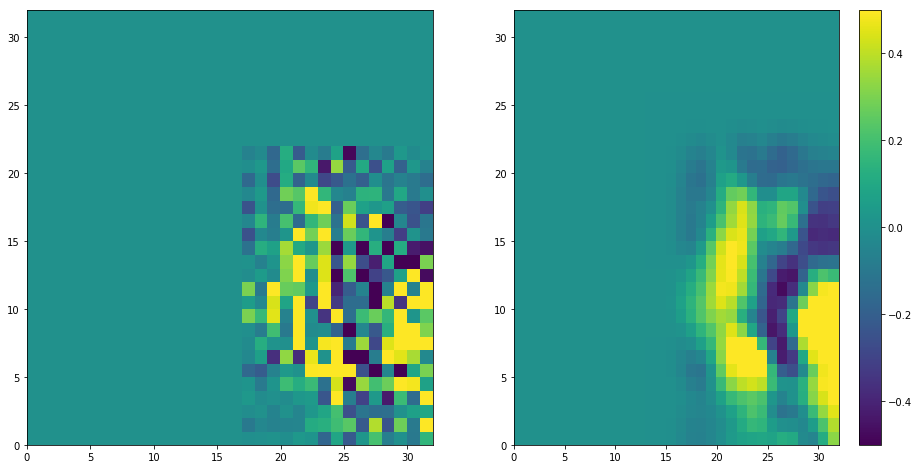

In [62]:
index = 1
out_channel = out_image[0, :, :, index]
out_pos = np.zeros(out_channel.shape)
out_neg = np.zeros(out_channel.shape)
out_pos[out_channel > 0] = out_channel[out_channel > 0]
out_neg[out_channel < 0] = out_channel[out_channel < 0]
print(out_channel.min(), out_neg.min())
max_pos = maximum_filter(out_pos, 3)
min_neg = minimum_filter(out_neg, 3)
out_proc = np.zeros(out_channel.shape)
out_proc[out_channel > 0] = max_pos[out_channel > 0]
out_proc[out_channel < 0] = min_neg[out_channel < 0]
out_proc = gaussian_filter(out_proc, 1)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.pcolormesh(out_channel, vmin=-0.5, vmax=0.5)
plt.subplot(1, 2, 2)
plt.pcolormesh(out_proc, vmin=-0.5, vmax=0.5)
plt.colorbar()

0.763314541895


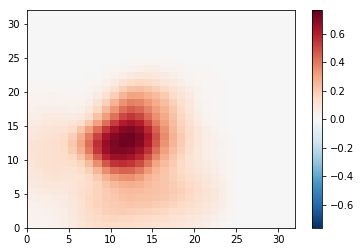

In [11]:
index = 5
v_max = np.max(np.abs(out_image[0, :, :, index]))
plt.pcolormesh(out_smooth[0, :, :, index], vmin=-v_max, vmax=v_max, cmap="RdBu_r")
plt.colorbar()
print(out_image[0, :, :, index].max())

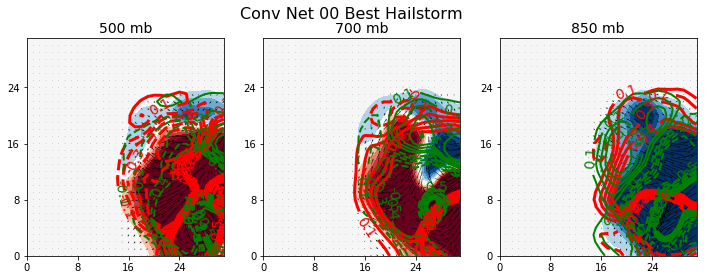

In [63]:
fig = plt.figure(figsize=(12, 4))
heights = [500, 700, 850]
for a in np.arange(3):
    plt.subplot(1,3, a + 1)
    conts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0.1, 0.2, 0.3, 0.4, 0.5]
    hght = plt.contourf(out_smooth[0, :, :, a], conts, extend="both", cmap="RdBu_r")
    tmpc = plt.contour(out_smooth[0, :, :, 3 + a], 
                       conts, linewidths=3, colors=["red"])
    plt.clabel(tmpc, fmt="%1.1f", fontsize=14)
    dewp = plt.contour(out_smooth[0, :, :, 6 + a], conts, linewidths=2, colors=["green"])
    plt.clabel(dewp, fmt="%1.1f", fontsize=14)
    u_g = out_smooth[0, :, :, 9 + a]
    v_g = out_smooth[0, :, :, 12 + a]
    #wind_mask = np.sqrt(out_smooth[0, :, :, 9 + a] ** 2 + out_smooth[0, :, :, 12 + a] ** 2) < 0.01
    #u_g[wind_mask] = 0
    #v_g[wind_mask] = 0
    plt.quiver(np.arange(32), np.arange(32), u_g,
              v_g, color="k")
    plt.xticks(np.arange(0, 32, 8))
    plt.yticks(np.arange(0, 32, 8))
    plt.title("{0:d} mb".format(heights[a]), fontsize=14)
plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(0), fontsize=16, y=0.99)
plt.savefig("/d1/dgagne/spatial_storm_results_20171220/hail_dream_figures/best_act_hail.png", dpi=200, bbox_inches="tight")

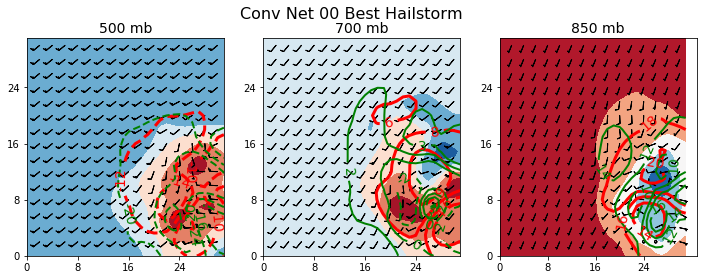

In [65]:
fig = plt.figure(figsize=(12, 4))
heights = [500, 700, 850]
for a in np.arange(3):
    plt.subplot(1,3, a + 1)
    hght = plt.contourf(out_orig[0, :, :, a], 4, extend="both", cmap="RdBu_r")
    tmpc = plt.contour(out_orig[0, :, :, 3 + a] - 273, 4, linewidths=3, colors=["red"])
    plt.clabel(tmpc, fmt="%1.0f", fontsize=14)
    dewp = plt.contour(out_orig[0, :, :, 6 + a] - 273, 4, linewidths=2, colors=["green"])
    plt.clabel(dewp, fmt="%1.0f", fontsize=14)
    u_g = out_orig[0, :, :, 9 + a]
    v_g = out_orig[0, :, :, 12 + a]
    #wind_mask = np.sqrt(out_smooth[0, :, :, 9 + a] ** 2 + out_smooth[0, :, :, 12 + a] ** 2) < 1
    #u_g[wind_mask] = 0
    #v_g[wind_mask] = 0
    plt.barbs(np.arange(2, 32, 2), np.arange(2, 32, 2), u_g[2::2, 2::2],
              v_g[2::2, 2::2], color="k", length=4)
    plt.xticks(np.arange(0, 32, 8))
    plt.yticks(np.arange(0, 32, 8))
    plt.title("{0:d} mb".format(heights[a]), fontsize=14)
plt.suptitle("Conv Net {0:02d} Best Hailstorm".format(0), fontsize=16, y=0.99)
plt.savefig("/d1/dgagne/spatial_storm_results_20171220/hail_dream_figures/best_act_hail_orig.png", dpi=200, bbox_inches="tight")

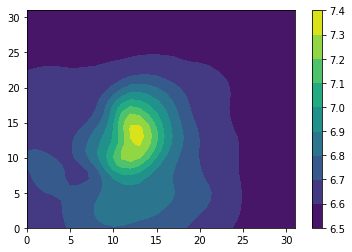

In [20]:
lapse_rate = -(out_orig[0, :, :, 3] - out_orig[0, :, :, 5]) / (out_orig[0, :, :, 0] - out_orig[0, :, :, 2]) * 1000
plt.contourf(lapse_rate)
plt.colorbar()

In [21]:
bwd = np.sqrt((out_orig[0, :, :, 9] - out_orig[0, :, :, 11]) ** 2 + (out_orig[0, :, :, 12] - out_orig[0, :, :, 14]) ** 2)

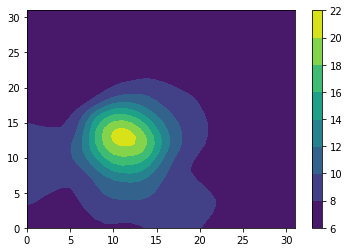

In [22]:
plt.contourf(bwd)
plt.colorbar()

0.0